In [47]:
import psycopg2
import pandas as pd
from datetime import datetime, timedelta
from sqlalchemy import create_engine

db_username = 'tupo'
db_password = 'npg_mbhaH6B3jdzy'
db_host = 'ep-bold-king-a52tlxdq-pooler.us-east-2.aws.neon.tech'
db_port = '5432'  # 默认为5432
db_name = 'day_ahead_spot'

conn = create_engine(f'postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}')

In [48]:
query = "SELECT * FROM day_ahead_marginal_data;"
df = pd.read_sql_query(query, conn)

In [49]:
from sqlalchemy import text
from decimal import Decimal
from datetime import timedelta

def estimate_clearing_price(engine, query_date, time_slot, rate_tolerance=0.01, lookback_days=5):
    rate_tolerance = Decimal(str(rate_tolerance))  # 将 float 转为 Decimal，避免精度问题
    
    with engine.connect() as connection:
        # 获取目标负荷率
        query = text("""
            SELECT day_ahead_load_rate_percent
            FROM day_ahead_marginal_data
            WHERE date = :query_date AND time_slot = :time_slot
        """)
        result = connection.execute(query, {"query_date": query_date, "time_slot": time_slot}).fetchone()
        if not result:
            return None
        target_rate = result[0]  # 这是 Decimal 类型

        # 查找近几天内相同时点且负荷率相近的数据
        start_date = query_date - timedelta(days=lookback_days)
        match_query = text("""
            SELECT day_ahead_clearing_price
            FROM day_ahead_marginal_data
            WHERE 
                date >= :start_date AND date < :query_date
                AND day_ahead_load_rate_percent BETWEEN :min_rate AND :max_rate
        """)
        prices = connection.execute(match_query, {
            "start_date": start_date,
            "query_date": query_date,
            "min_rate": target_rate - rate_tolerance,
            "max_rate": target_rate + rate_tolerance
        }).fetchall()
        # print("Executing query:", match_query)
        # print("With parameters:", start_date, query_date, time_slot, target_rate - rate_tolerance, target_rate + rate_tolerance)
        prices = [price[0] for price in prices]
        return sum(prices) / len(prices) if prices else None

In [50]:
target_date = datetime.strptime("2025-04-01", "%Y-%m-%d").date()
test = estimate_clearing_price(conn,target_date, "00:15:00",1,5)
print(test)

296.3333333333333333333333333


In [ ]:
target_date = datetime.strptime("2025-04-01", "%Y-%m-%d").date()

# 生成所有96个时点（15分钟一个）
time_slots = [f"{hour:02}:{minute:02}:00" 
              for hour in range(24) 
              for minute in range(0, 60, 15)]

results = []
for time_str in time_slots:
    time_slot = datetime.strptime(time_str, "%H:%M:%S").time()
    avg_price = estimate_clearing_price(conn, target_date, time_slot,1,30)
    results.append({
        "date": target_date,
        "time_slot": time_slot,
        "estimated_price": avg_price
    })

result_df = pd.DataFrame(results)

In [84]:
result_df
# 找到 time_slot 为 '00:00:00' 的行
midnight_row = result_df[result_df['time_slot'] == '00:00:00']

# 移除 time_slot 为 '00:00:00' 的行
result_df = result_df[result_df['time_slot'] != '00:00:00']

# 将 midnight_row 追加到 result_df 的末尾
result_df = pd.concat([result_df, midnight_row], ignore_index=True)

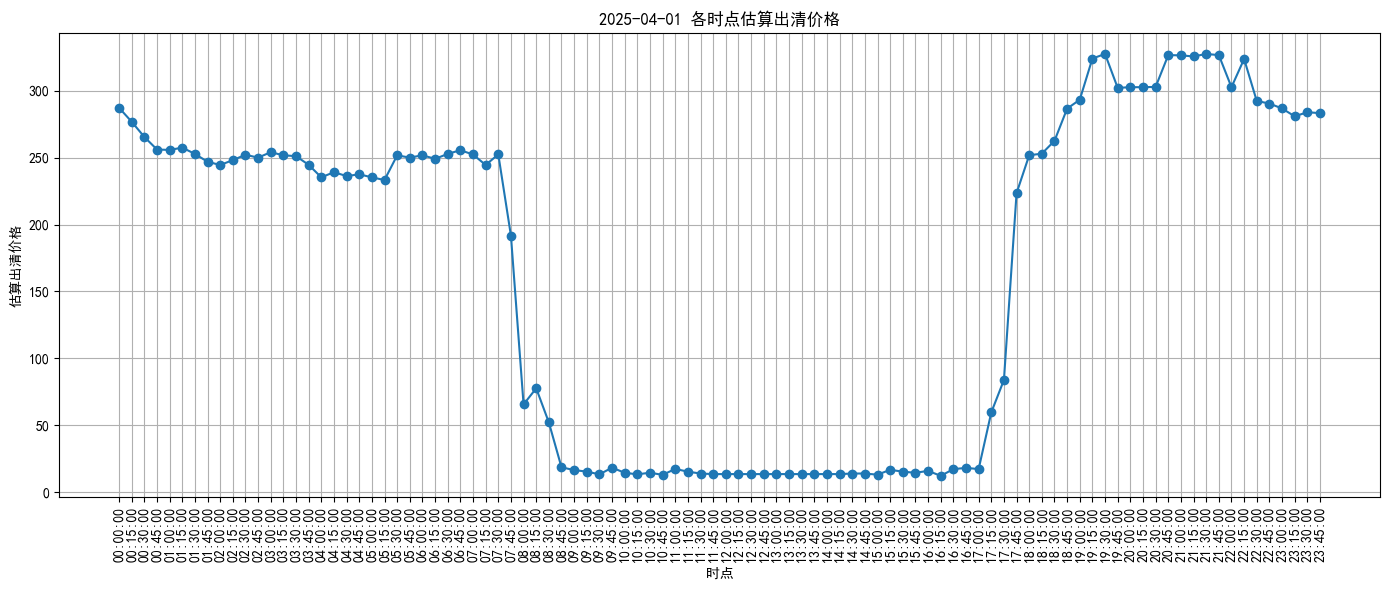

In [85]:
import matplotlib.pyplot as plt

# 转换 time_slot 为字符串，用作横坐标
result_df["time_str"] = result_df["time_slot"].astype(str)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示为方块的问题
# 绘图
plt.figure(figsize=(14, 6))
plt.plot(result_df["time_str"], result_df["estimated_price"], marker='o')
plt.title(f"{result_df['date'].iloc[0]} 各时点估算出清价格")
plt.xlabel("时点")
plt.ylabel("估算出清价格")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [96]:
query = """
    SELECT time_slot, day_ahead_clearing_price
    FROM day_ahead_marginal_data
    WHERE date = '2025-04-01'
"""
actual_prices_df = pd.read_sql_query(query, conn)

In [97]:
actual_prices_df['time_slot'] = actual_prices_df['time_slot'].astype(str)
comparison_df = pd.merge(result_df, actual_prices_df, on='time_slot', how='inner', suffixes=('_estimated', '_actual'))
# 将 'estimated_price' 列转换为 float 类型
comparison_df['estimated_price'] = comparison_df['estimated_price'].astype(float)

# 计算价格差异
comparison_df['price_difference'] = comparison_df['estimated_price'] - comparison_df['day_ahead_clearing_price']

In [94]:
comparison_df['price_difference']

Series([], Name: price_difference, dtype: float64)

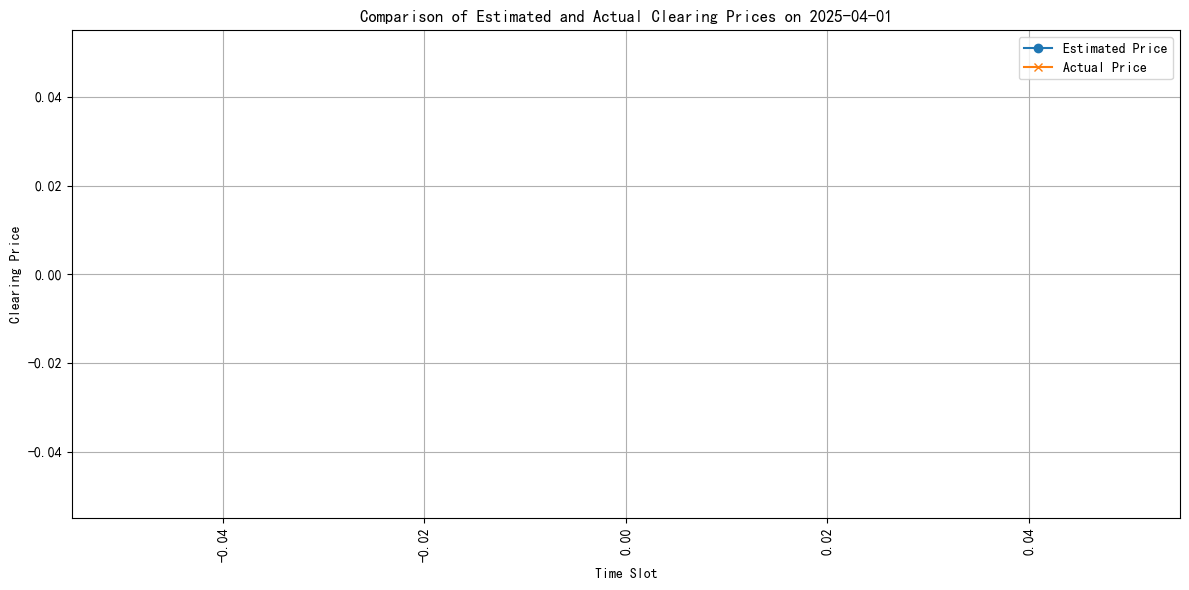

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison_df['time_slot'], comparison_df['estimated_price'], label='Estimated Price', marker='o')
plt.plot(comparison_df['time_slot'], comparison_df['day_ahead_clearing_price'], label='Actual Price', marker='x')
plt.xticks(rotation=90)
plt.xlabel('Time Slot')
plt.ylabel('Clearing Price')
plt.title('Comparison of Estimated and Actual Clearing Prices on 2025-04-01')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
conn.close()